In [129]:
# import packages
import numpy as np
import pandas as pd
import copy
import os
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageDraw

# Week 3: CNN Cancer Detection Kaggle Mini-Project
### In this mini project, I solve a binary image classification problem where I will identify metastatic cancer in small image patches taken from larger digital pathology scans.  
#  
### This notebook consists of the table of contents below.
#### 1. description of the problem/data
#### 2. exploratory data analysis (EDA)
#### 3. model building and training
#### 4. result
#### 5. conclusion


### 1. Description of the problem / Data

#### A. Problem
+ The problem is mainly a BINARY IMAGE CLASSIFICATION PROBLEM. The Problem focuses on identifying the presence of metastases from a 96 * 96 digital histopathology images
+ One key challenge is that the metastases can be as small as single cells in a large area of tissue.
  
#### B. DATA
+ The dataset contains the histopathological Images, each image is 96px * 96px.
+ A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

### 2. Exploratory Data Analysis (EDA)
### Preprocessing Dataset

In [130]:
# load dataset
labels = pd.read_csv('/content/train_labels.csv')
print(labels.head())
print(labels.shape)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
(220025, 2)


In [131]:
print(f'{len(os.listdir("/content/test"))} pictures in train.')
print(f'{len(os.listdir("/content/test"))} pictures in test.')

57458 pictures in train.
57458 pictures in test.


In [132]:
# Duplicated Check
labels[labels.duplicated(keep=False)]

,id,label


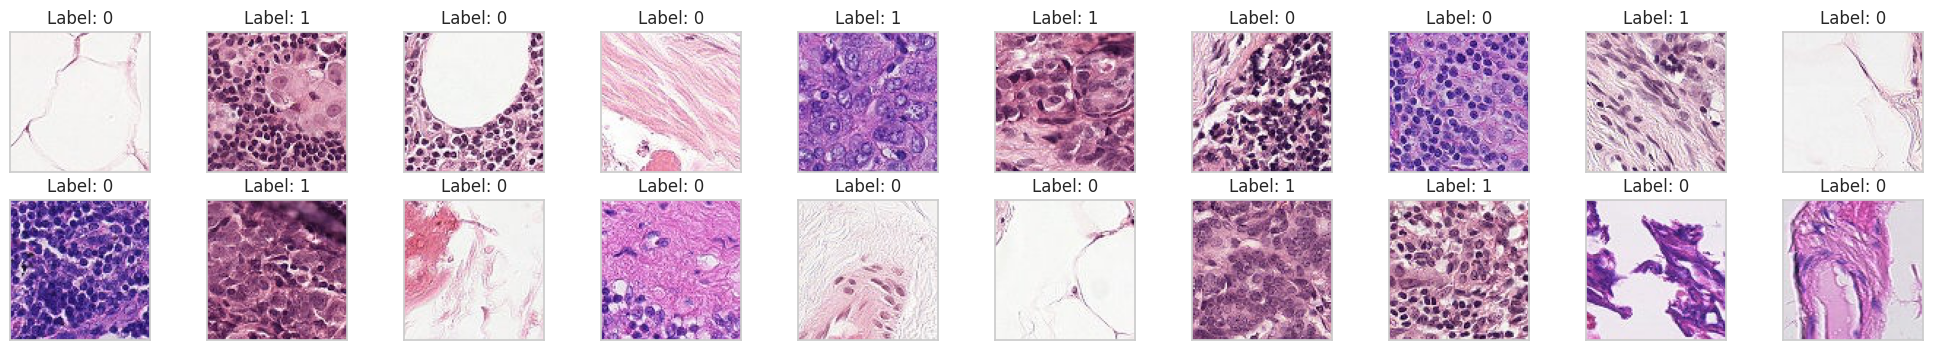

In [133]:
# Check Images
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir("/content/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("/content/train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

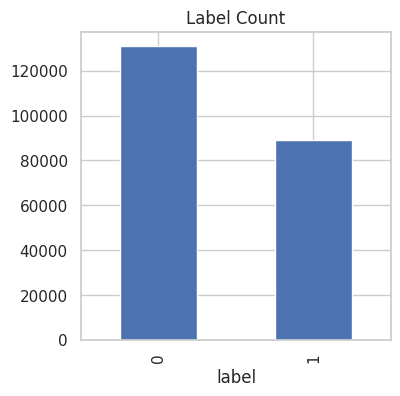

label
0    130908
1     89117
Name: count, dtype: int64


In [134]:
# Check Imbalanced
f, ax = plt.subplots(1, 1, figsize=(4, 4))
labels['label'].value_counts().plot.bar(ax=ax)
ax.set_title('Label Count')
plt.show()
print(labels['label'].value_counts())

So, malignant(1) vs normal(0) is balanced.


Text(0.5, 0.94, 'normal images')

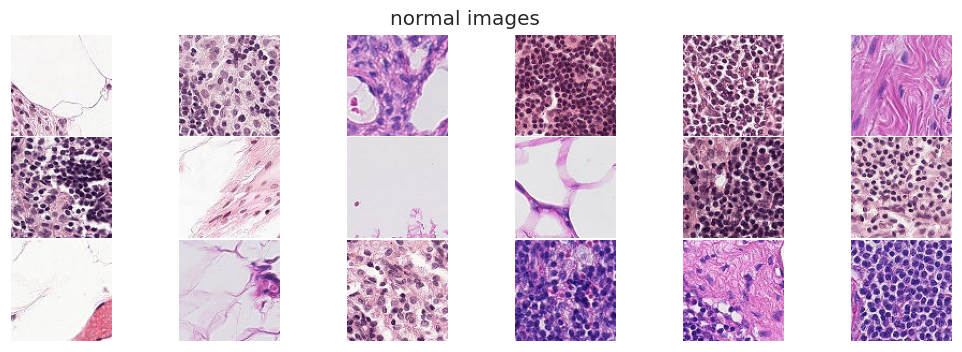

In [135]:
# normal images (0)

normal = labels.loc[labels['label']==0]['id'].values

fig,ax = plt.subplots(3,6,figsize=(13,4))
plt.subplots_adjust(wspace=0, hspace=0)
for i,j in enumerate(normal[:3*6]):
    fname = os.path.join('/content/train/' ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='white')
    plt.subplot(3, 6, i+1)
    plt.imshow(np.array(img))
    plt.axis('off')

plt.suptitle('normal images', y=0.94)

Text(0.5, 0.94, 'malignant images')

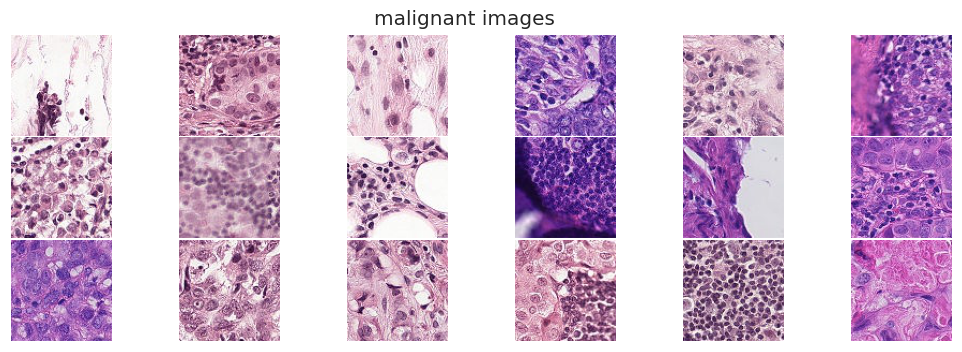

In [136]:
# malignant images (1)

malignant = labels.loc[labels['label']==1]['id'].values

fig,ax = plt.subplots(3,6,figsize=(13,4))
plt.subplots_adjust(wspace=0, hspace=0)
for i,j in enumerate(malignant[:3*6]):
    fname = os.path.join('/content/train/' ,j +'.tif')
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline='white')
    plt.subplot(3, 6, i+1)
    plt.imshow(np.array(img))
    plt.axis('off')

plt.suptitle('malignant images', y=0.94)

### 3. Model building and training
### Load Dataset

In [137]:
import time
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch import optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchsummary import summary

In [138]:
torch.manual_seed(0) # fix random seed

class pytorch_data(Dataset):

    def __init__(self,data_dir,transform,data_type="train"):

        # Get Image File Names
        cdm_data=os.path.join(data_dir,data_type)  # directory of files

        file_names = os.listdir(cdm_data) # get list of images in that directory
        idx_choose = np.random.choice(np.arange(len(file_names)),
                                      10000,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]   # get the full path to images

        # Get Labels
        labels_data=os.path.join(data_dir,"train_labels.csv")
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True) # set data frame index to id
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]  # obtained labels from df
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames) # size of dataset

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]

Get random 10,000 images

In [139]:
data_transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((46,46))])
img_dataset = pytorch_data('/content/', data_transformer, "train") # Histopathalogic images

In [140]:
len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(img_dataset, [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 8000
validation dataset size: 2000


In [141]:
# Define the following transformations for the training dataset
tr_transf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor()])

# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [142]:
# Training DataLoader
train_dl = DataLoader(train_ts, batch_size=32, shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts, batch_size=32, shuffle=False)

#### Model building

In [143]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(Network, self).__init__()

        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"]
        num_fc1=params["num_fc1"]
        num_classes=params["num_classes"]
        self.dropout_rate=params["dropout_rate"]

        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)

        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [144]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,46,46),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [145]:
summary(cnn_model, input_size=(3, 46, 46),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2           [-1, 16, 20, 20]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Conv2d-4             [-1, 64, 2, 2]          18,496
            Linear-5                  [-1, 100]           6,500
            Linear-6                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


#### Model training

In [146]:
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [147]:
''' Helper Functions'''

# Function to get the learning rate
def get_last_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

In [148]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value

    ''' Train Model n_epochs '''

    for epoch in tqdm(range(epochs)):

        ''' Get the Learning Rate '''
        current_lr=get_last_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        '''

        Train Model Process

        '''

        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        '''

        Evaluate Model Process

        '''

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_last_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [149]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": opt,
 "lr_change": lr_scheduler,
 "f_loss": loss_func,
 "weight_path": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

### 4. Result
#### Model evaluation
Loss & Accuracy Plot

Text(0.5, 1.0, 'Convergence History')

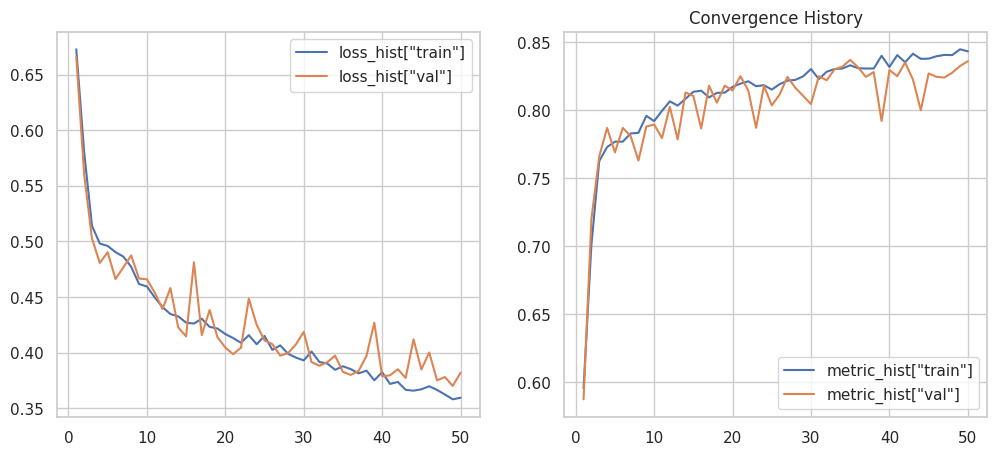

In [151]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')

Inference and create submission.csv

In [150]:
class pytorchdata_test(Dataset):

    def __init__(self, data_dir, transform,data_type="train"):

        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [152]:
cnn_model.load_state_dict(torch.load('weights.pt'))

# sample submission
path_sub = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"

data_transformer = transforms.Compose([transforms.ToTensor(), transforms.Resize((46,46))])

img_dataset_test = pytorchdata_test('/content/',data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

57458 samples found


In [153]:
def inference(model,dataset,device,num_classes=2):

    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device

    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt

In [154]:
y_test_out,_ = inference(cnn_model,img_dataset_test, device)

  0%|          | 0/57458 [00:00<?, ?it/s]

(57458,)
[0 0 0 0 0]


In [169]:
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

(57458,)
[0 0 0 0 0]


In [170]:
pred_labels = pd.read_csv("/content/sample_submission.csv")

test_preds = pd.DataFrame({'imgs': pred_labels['id'], 'preds': y_test_pred})


In [167]:
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])
sub = pd.read_csv('/content/sample_submission.csv')
sub = pd.merge(sub, test_preds, left_on='id', right_on='imgs')
sub = sub[['id', 'preds']]
sub.columns = ['id', 'label']
sub.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.077000
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.198356
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.027790
3,2c35657e312966e9294eac6841726ff3a748febf,0.052834
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.097946


In [168]:
sub.to_csv('sub.csv', index=False)

### 5. Conclusion

The learning process using the entire data took a long time, so the learning and validation were conducted using 10,000 random data. When I check the loss and Accuracy plot, it is confirmed that they converge well. It is expected that better scores can be obtained by increasing the number of epochs or using more data.
<br>

##### Additional Considerations
1. Data augmentation - Need to leverage Domain knowledge on
2. Proper hyperparameters settings
3. Better architecture configuration